# TTI Explorer

#### `tti_explorer` is a library for simulating infection spread. This library is built to explore the impact of various test-trace-isolate strategies and social distancing measures on the spread of COVID-19 in the UK. 

This notebook is an introduction to the functionality offered by `tti-explorer`. 

In [4]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
/content/tti-explorer


In [5]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

In [6]:
def print_doc(func):
    print(func.__doc__)

#Installations

In [1]:
%pip install gpy

     |████████████████████████████████| 1.0MB 6.0MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
  Created wheel for gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633949 sha256=ef7b157f94a8435752dbc5f40538945c8f8326f350a41ba703295189e66da891
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=592470873641879b0ec7bdbef9c3376246a50531fc84dd3334762e3cc6c5438f
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz


In [2]:
%pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=55c169820c1841c1c6a3df998febc95736d6df43535e274059185416b9e4d8e9
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [3]:
%pip install emukit

     |████████████████████████████████| 122kB 5.0MB/s 
     |████████████████████████████████| 31.2MB 133kB/s 
  Created wheel for emukit: filename=emukit-0.4.7-cp36-none-any.whl size=188045 sha256=c32423154b262b0c13912b341b9252fe15ea8ad31020730126efc0e9e00e8222
  Stored in directory: /root/.cache/pip/wheels/37/d9/0c/31e157b6c2834699041b1b4cdf76898474c010ac53543d0611
  Created wheel for emcee: filename=emcee-2.2.1-cp36-none-any.whl size=29597 sha256=ac6f6f38b206315f9ecbb35bfa8d30ca683ae82dde05afa1a7c8d08940f67e29
  Stored in directory: /root/.cache/pip/wheels/2f/5d/a5/78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
Successfully built emukit emcee
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 

In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#Run

Before we do anything, let's make a random state

In [9]:
rng = np.random.RandomState(0)

In [10]:
import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt

We will first do a short tour of the functionality, then show how this is put together to generate simulation results.

## Generate a case

The function we use for this is `simulate_case` in `case.py`

In [11]:
print_doc(simulate_case)

simulate_case

    Args:
        rng (np.random.RandomState): random number generator.
        p_under18 (float): Probability of case being under 18
        infection_proportions (dict): Probs of being symp covid neg, symp covid pos, asymp covid pos
                                      The only required key is 'dist', which contains list of the named probs, in that order.
        p_day_noticed_symptoms (np.array[float]): Distribution of day on which case notices
            their symptoms. (In our model this is same as reporting symptoms.)
            Conditional on being symptomatic.
        inf_profile (list[float]): Distribution of initial exposure of positive secondary cases
            relative to start of primary case's infectious period.

    Returns (Case): case with attributes populated.
    


We store our config values in `config.py`. You can retrieve them as follows

In [12]:
case_config = config.get_case_config("delve")
case_config.keys()

print(case_config)

{'p_under18': 0.21, 'infection_proportions': {'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 'nppl': 120}, 'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]}


We use these parameters to simulate a case

In [17]:
primary_case = simulate_case(rng, **case_config)
print_doc(primary_case)

print(primary_case)

Case(under18:bool, covid:bool, symptomatic:bool, day_noticed_symptoms:int, inf_profile:list)
Case(under18=False, covid=True, symptomatic=True, day_noticed_symptoms=2, inf_profile=array([0.0469661 , 0.15602256, 0.19829975, 0.18356485, 0.14541407,
       0.10500447, 0.07130993, 0.04635772, 0.02916789, 0.01789265]))


Returned is a `case.Case` with stochastically generated attributes.

### Deeper: Case attributes

Let's go through the simulated attributes of a `case.Case`. The attributes `.under18`, `.covid` and `.symptomatic` are `bool` types indicating whether the generated `case.Case` is under 18, COVID positive and symptomatic respectively. All possible values of these attributes are possible apart from the combination `.covid = False` and `.symptomatic = False` (a configuration irrelevant for the purpose of simulating infection spread). The primary case we just simulated has the following attributes:

In [18]:
print(f'Under 18: {primary_case.under18}.')
print(f'COVID positive: {primary_case.covid}.')
print(f'Symptomatic: {primary_case.symptomatic}.')

Under 18: False.
COVID positive: True.
Symptomatic: True.


Each `case.Case` also has an attribute `.day_noticed_symptoms` of type `int`, indicating the number of days from start of infectiousness until the `case.Case` noticed the symptoms. If a `case.Case` is asymptomatic, the attribute `.day_noticed_symptoms` is set to `-1`.

In [19]:
print(f'primary_case noticed symptoms {primary_case.day_noticed_symptoms} days after start of infectiousness.')

primary_case noticed symptoms 2 days after start of infectiousness.


Finally, the attribute `.inf_profile` is a `list` describing the relative infectiousness of the case for each day of the infectious period. If `.covid = False` for a `case.Case`, this is `0` throughout.

In [20]:
print(f'inf_profile is: {primary_case.inf_profile}')

inf_profile is: [0.0469661  0.15602256 0.19829975 0.18356485 0.14541407 0.10500447
 0.07130993 0.04635772 0.02916789 0.01789265]


As mentioned above, the configuration for simulating these attributes are stored in `config.py`. This includes the distributions used for sampling attributes. For instance, the attribute `.under18` is sampled from a Bernoulli distribution with probability `0.21`: 

In [21]:
print(f'Probability of case being under 18: {case_config["p_under18"]}')

Probability of case being under 18: 0.21


As another example, if `case.Case` is symptomatic, the attribute `.days_noticed_symptoms` is sampled from a categorical distribution over the set {0, 1, ..., 9} (since we model an infection period of ten days in this configuration) with probabilities:

In [22]:
print(f'Probability distribution of .day_noticed_symptoms: {case_config["p_day_noticed_symptoms"]}')

Probability distribution of .day_noticed_symptoms: [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0]


## Generate contacts
Social contacts are represented by `Contacts` and defined in `contacts.py`.

To simulate social contacts, we use the BBC Pandemic Dataset. This is stratified as over/under 18 to give different patterns of social contact depending on the age of the case. 

In [23]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [24]:
path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

Now that we have the data loaded, we use `EmpiricalContactsSimulator` to sample these tables for contacts of the primary case, then simulate their infection under a no measures scenario (i.e. no government intervention)

In [25]:
print_doc(EmpiricalContactsSimulator.__init__)

Simulate social contact using the BBC Pandemic dataset

            Each row in input arrays consists of three numbers,
            represeting number of contacts at: home, work, other

        Args:
            over18 (np.array[int], Nx3): Contact data for over 18s.
            under18 (np.array[int], Nx3): Contact data for under 18s.
            rng (np.random.RandomState): Random state.

        


In [26]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

We can now use the callable `simulate_contacts` to simulate social contacts of the primary case

In [27]:
print_doc(simulate_contacts.__call__)

Generate a social contact for the given case.

        A row from the table corresponding to the age of the `case` is sampled
        uniformly at random. A contact is generated with daily contacts as
        given by that row. These contacts are infected at random with attack rates
        given by the SARs and whether or not the `case` is symptomatic. If the
        `case` is COVID negative, then no contacts are infected.

        Args:
            case (Case): Primary case.
            home_sar (float): Secondary attack rate for household contacts.
                              (Marginal probability of infection over the whole simulation)
            work_sar (float): Secondary attack rate for contacts in the work category.
            other_sar (float): Secondary attack rate for contacts in the other category.
            asymp_factor (float): Factor by which to multiply the probabilty of secondary
                                  infection if `case` is asymptomatic COVID positive

To do this we need some more parameters, which we also load from `config.py`. The user can, of course, specify this themselves if they would like.

In [28]:
contacts_config = config.get_contacts_config("delve")

In [31]:
contacts_config.keys()

dict_keys(['home_sar', 'work_sar', 'other_sar', 'period', 'asymp_factor'])

In [32]:
print(contacts_config)

{'home_sar': 0.3, 'work_sar': 0.045, 'other_sar': 0.045, 'period': 10, 'asymp_factor': 0.5}


We now do the same as we did with when simulating a primary case.

In [33]:
social_contacts = simulate_contacts(primary_case, **contacts_config)
print_doc(social_contacts)

print(social_contacts)

Contacts(n_daily:dict, home:<built-in function array>, work:<built-in function array>, other:<built-in function array>)
Contacts(n_daily={'home': 2, 'work': 14, 'other': 3}, home=array([[-1,  0],
       [ 1,  0]]), work=array([[-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  0],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [ 1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  1],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [ 2,  2],
       [-1,  2],
       [-1,  2],
       [ 2,  2],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [-1,  2],
       [-1,  3],
       [-1,  3],
       [ 3,  3],
       [-1,  3]

### Deeper: Contacts attributes

Let's examine the attributes of `social_contacts`, which is an instance of `contacts.Contacts`. Note that `social_contacts` is simulated above by calling `simulate_contacts` which takes `primary_case` as in argument, so contact generation of course depends on the case simulated first. 

The first attribute to note is `.n_daily`, which is a `dict` containing the average number of daily contacts (split into three categories) of the case. This is simulated by sampling one row of the tables `over18` or `under18` depending on the value of `primary_case.under18`. In the case of `primary_case`, we can look at `social_contacts.n_daily`:

In [34]:
print(f'Average number of daily contacts for primary_case:')
print(f'Home: {social_contacts.n_daily["home"]}')
print(f'Work: {social_contacts.n_daily["work"]}')
print(f'Other: {social_contacts.n_daily["other"]}')

Average number of daily contacts for primary_case:
Home: 2
Work: 14
Other: 3


The three remaining attributes `.home`, `.work` and `.other` are arrays containing information about each contact made by the case, with one row per contact. More specifically, for each contact, the row contains the first day (always measured relative to the start of infectiousness) of encounter between the case and contact and, if transmission occurred, then the day of transmission. 

Also, recall that home contacts are assumed to repeat every day of the infectious period, whereas work/other contacts are new for each day. This means the lengths of the arrays `.work` and `.other` are `10 * .n_daily['work']` and `10 * .n_daily['other']` respectively (recalling the infection period is assumed to last ten days, a parameter set in `contacts_config['period']`). Whereas, the length of the `.home` array is just `.n_daily['home']`.

In [35]:
print(f'Lengths of .home, .work and .other attributes:')
print(f'Home: {len(social_contacts.home)}')
print(f'Work: {len(social_contacts.work)}')
print(f'Other: {len(social_contacts.other)}')

Lengths of .home, .work and .other attributes:
Home: 2
Work: 140
Other: 30


Digging further into the array, each row contains two integers. The first integer indicates the day of transmission, which is set to `-1` if no transmission occurred. The second integer contains the day of first encounter. So for instance, looking at one of the home contacts, we see transmission didn't occur and the day of first encounter is `0`, i.e. the first day of the infection period:

In [36]:
print(social_contacts.home[0])

[-1  0]


Looking at the first six work contacts, we see none of them were infected either. This is consistent with the fact that `primary_case.covid = False` so no transmission can occur in this case.

In [37]:
print(social_contacts.work[:6])

[[-1  0]
 [-1  0]
 [-1  0]
 [-1  0]
 [-1  0]
 [-1  0]]


In simulations where `case.Case` is COVID positive, each contact may get infected and the probability of getting infected depends on parameters such as the secondary attack rates (SARs), all of which are set in `contacts_config`. For details on the precise simulation procedure used to generate `contacts.Contacts`, see either Appendix A of the report or the `__call__` method of `EmpiricalContactsSimulator`.

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [38]:
from tti_explorer.strategies import TTIFlowModel

We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

First get the configurations:

In [68]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [69]:
rng = np.random.RandomState(42)

Make contact simulator:

In [70]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [71]:
tti_model = TTIFlowModel(rng, **strategy_config)

In [72]:
print(case_config)

{'p_under18': 0.21, 'infection_proportions': {'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 'nppl': 120}, 'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]}


Generate cases, contacts and run simulation:

**Case Config**

In [113]:
p_under18 = 0.21 # @param {type:"number"}
case_config = {
    'p_under18': p_under18, 
    'infection_proportions': {
        'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 
        'nppl': 120
        }, 
    'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 
    'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]
    }

**Contact Config**

In [114]:
home_sar = 0.3 # @param {type:"number"}
work_sar = 0.045 # @param {type:"number"}
other_sar = 0.045 # @param {type:"number"}
period = 10 # @param {type:"number"}
asymp_factor = 0.5 # @param {type:"number"}
contacts_config = {
   'home_sar': home_sar, 
   'work_sar': work_sar, 
   'other_sar': other_sar, 
   'period': period, 
   'asymp_factor': asymp_factor
   }

**Policy Config**

In [115]:
policy_compliance = 0.8 # @param {type: "slider", min: 0, max: 1, step: 0.1}
policy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': 2, 
    'app_trace_delay': 0, 
    'manual_trace_delay': 1, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': 10, 
    'quarantine_length': 14, 
    'latent_period': 3, 
    'app_cov': 0.35, 
    'compliance': compliance, 
    'go_to_school_prob': 0.5, 
    'wfh_prob': 0.45
    }

**Factor Config**

In [116]:
factor_compliance = 0.8 # @param {type: "slider", min: 0, max: 1, step: 0.1}
factor_config = {
    'app_cov': 0.35, 
    'compliance': factor_compliance, 
    'go_to_school_prob': 0.5, 
    'wfh_prob': 0.45
    }

**Strategy Config**

In [117]:
strategy_quarantine_length = 14 # @param {type: "number"}
strategy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': 2, 
    'app_trace_delay': 0, 
    'manual_trace_delay': 1, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': 10, 
    'quarantine_length': strategy_quarantine_length, 
    'latent_period': 3, 
    'app_cov': 0.35, 
    'compliance': 0.8
    }

In [118]:
n_cases = 10000
outputs = list()

for _ in trange(n_cases):
    case = simulate_case(rng, **case_config)
    contacts = simulate_contacts(case, **contacts_config)
    while contacts.n_daily['work'] < 10: # keep regen popular kids
      case = simulate_case(rng, **case_config)
      contacts = simulate_contacts(case, **contacts_config) 
    case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
    res = tti_model(case, contacts, case_factors)
    outputs.append(res)

In [119]:
for o in outputs:
  if o['Base R'] is not np.nan:
    print(o)

{'Base R': 6, 'Effective R': 0.0, '# Manual Traces': 0, '# App Traces': 0, '# Tests Needed': 1.0, '# PersonDays Quarantined': 14, 'Has Covid': True, 'Is Symptomatic': True, 'Got tested': True, '# Secondary Infections': 6, '# Secondary Infections Prevented by Social Distancing': 6, '# Secondary Infections Prevented by Isolating Cases with Symptoms': 0.0, '# Secondary Infections Prevented by Contact Tracing': 0.0, 'Fractional R': 0.0}
{'Base R': 4, 'Effective R': 0.24995475885902071, '# Manual Traces': 22, '# App Traces': 0, '# Tests Needed': 1.0, '# PersonDays Quarantined': 266, 'Has Covid': True, 'Is Symptomatic': True, 'Got tested': True, '# Secondary Infections': 4, '# Secondary Infections Prevented by Social Distancing': 0, '# Secondary Infections Prevented by Isolating Cases with Symptoms': 2.0, '# Secondary Infections Prevented by Contact Tracing': 1.7500452411409793, 'Fractional R': 0.24995475885902071}
{'Base R': 10, 'Effective R': 0.0, '# Manual Traces': 4, '# App Traces': 0, '

Collate and average results across the cases simulated:

In [101]:
# This cell is mosltly just formatting results...
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r,
    RETURN_KEYS.man_trace,
    RETURN_KEYS.app_trace,
    RETURN_KEYS.tests
]

# scale factor to turn simulation numbers into UK population numbers
nppl = case_config['infection_proportions']['nppl']
scales = [1, 1, nppl, nppl, nppl]

results = pd.DataFrame(
    outputs
).mean(
    0
).loc[
    to_show
].mul(
    scales
).to_frame(
    name=f"Simulation results: {name.replace('_', ' ')}"
).rename(
    index=lambda x: x + " (k per day)" if x.startswith("#") else x
)

results.round(1)

,Simulation results: S3 test based TTI
Base R,8.9
Effective R,2.7
# Manual Traces (k per day),308.5
# App Traces (k per day),40.5
# Tests Needed (k per day),90.2


In [100]:
results = pd.DataFrame(outputs).mean(0)
print(results.loc["Base R"])

8.920702179176756


In [139]:
# A basic simulation for experimenting for experimenting with surrogate models
def loss_function(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    case_config['p_under18'] = x[i,0]
    contacts_config['home_sar'] = x[i,1]
    contacts_config['work_sar'] = x[i,2]
    contacts_config['other_sar'] = x[i,3]

    n_cases = 10000
    outputs = list()

    for _ in trange(n_cases):
        case = simulate_case(rng, **case_config)
        contacts = simulate_contacts(case, **contacts_config)
        '''
        while contacts.n_daily['work'] < 10: # keep regen popular kids
          case = simulate_case(rng, **case_config)
          contacts = simulate_contacts(case, **contacts_config)
        ''' 
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Base R"])
  return y
   
   

In [143]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
           
space = ParameterSpace(
          [ContinuousParameter('p_under18', *variable_domain), 
           ContinuousParameter('home_sar', *reduced_variable_domain),
           ContinuousParameter('work_sar', *reduced_variable_domain),
           ContinuousParameter('other_sar', *reduced_variable_domain)])

design = RandomDesign(space)
x = design.get_samples(5)
y = loss_function(x)

model_gpy = GPRegression(x,y)
model_gpy.kern.variance = 150**2
model_gpy.likelihood.variance.fix(1e-5)
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,22500.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [144]:
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

Optimization restart 1/1, f = 20.27516620849224


 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [145]:
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,22499.997828144078,+ve,
rbf.lengthscale,5.300422631783679,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [146]:
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition = integrated_variance)
ed.run_loop(loss_function, 10)

 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/1, f = 20.275166202537783



Optimization restart 1/1, f = 22.006108177031763



Optimization restart 1/1, f = 23.540827944676526



Optimization restart 1/1, f = 24.043821347011114



Optimization restart 1/1, f = 27.841583048904713



Optimization restart 1/1, f = 29.710987838849306



Optimization restart 1/1, f = 32.01107313536116



Optimization restart 1/1, f = 32.81900486407434



Optimization restart 1/1, f = 41.51951585743424



Optimization restart 1/1, f = 45.3777516644179



Optimization restart 1/1, f = 47.107266973950296


Sensitivty Analysis of Pandemic Simulation

In [147]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

Text(0, 0.5, '% of explained output variance')

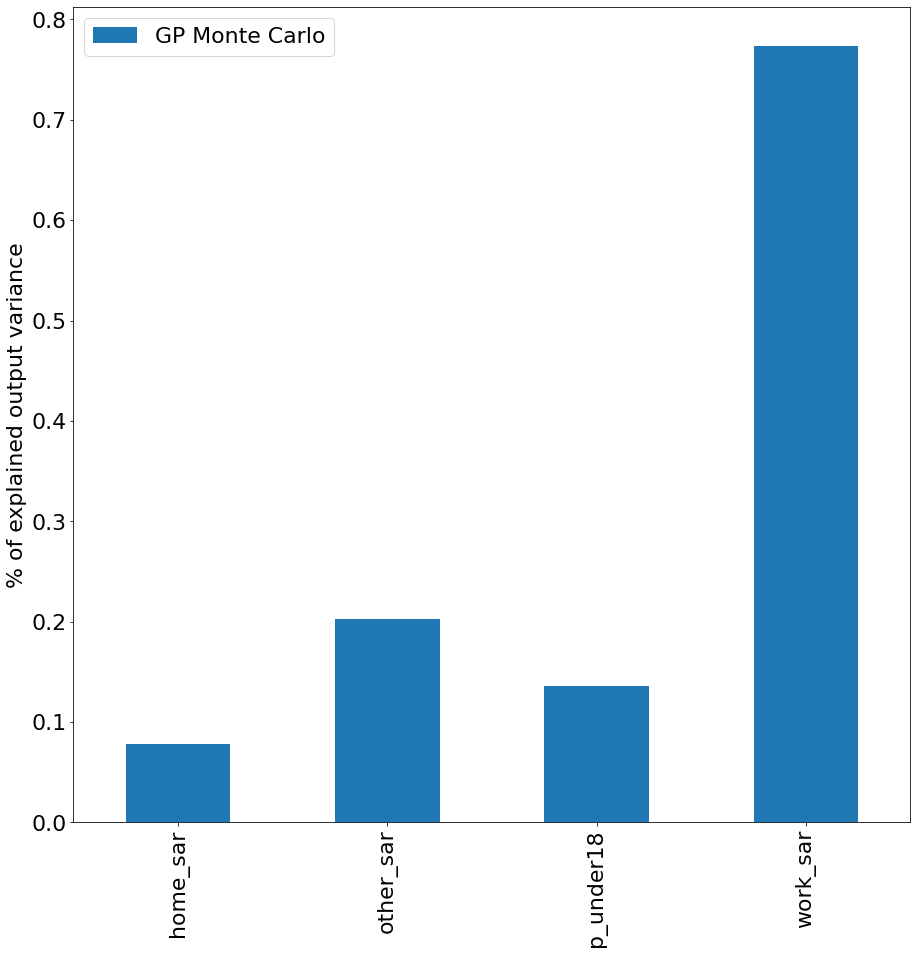

In [148]:
fig, ax = plt.subplots(figsize=(15,15))

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')